In [6]:
import nidaqmx
import nidaqmx.constants
import nidaqmx.errors
import nidaqmx.stream_writers
import nidaqmx.stream_readers

import datetime
import pathlib
import enum
import time
from copy import deepcopy
from pprint import pprint

from ruamel.yaml import YAML
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

%matplotlib inline

In [7]:
import importlib
import ad9912
import ad9959
importlib.reload(ad9912)
importlib.reload(ad9959)

AD9959 = ad9959.AD9959
AD9912 = ad9912.AD9912

import words_to_bits
importlib.reload(words_to_bits)
prepare_sequence_for_spi = words_to_bits.prepare_sequence_for_spi

import ttlplot
importlib.reload(ttlplot)
ttl_plot = ttlplot.ttl_plot

In [8]:
def get_current_shot_number(date=None, strformat='shot_{date:%Y%m%d}_*.gz', dir='data/'):
    if date is None:
        date = datetime.datetime.now()
    files = list(pathlib.Path(dir).glob(strformat.format(date=date)))
    if files:
        last_shot = max((int(file.stem.split('_')[-1]) for file in files))
        return last_shot + 1
    return 0

In [19]:
yaml = YAML(typ='safe', pure=False)
t0 = time.perf_counter()
with open('conf/nidaq-conf.yaml', 'r') as f:
    nidaq_conf = yaml.load(f)
with open('conf/dds-conf.yaml', 'r') as f:
    dds_conf = yaml.load(f)

with open('sequences/full-sequence.yaml', 'r') as f:
    sequence_conf = yaml.load(f)
    
seq_settings = sequence_conf['settings']
seq_phases = sequence_conf['phases']
print('Took {:.1f} ms'.format(1e3*(time.perf_counter() - t0)))

Took 5.1 ms


In [20]:
def find_phase_by_name(phases, name):
    found_phase = None
    for phase in phases:
        if phase['name'] == name:
            found_phase = phase
            break
    if found_phase is None:
        raise IndexError('No phase named {}.'.format(name))
    return phase

Sequence length : 185.4 ms
Took 7 ms


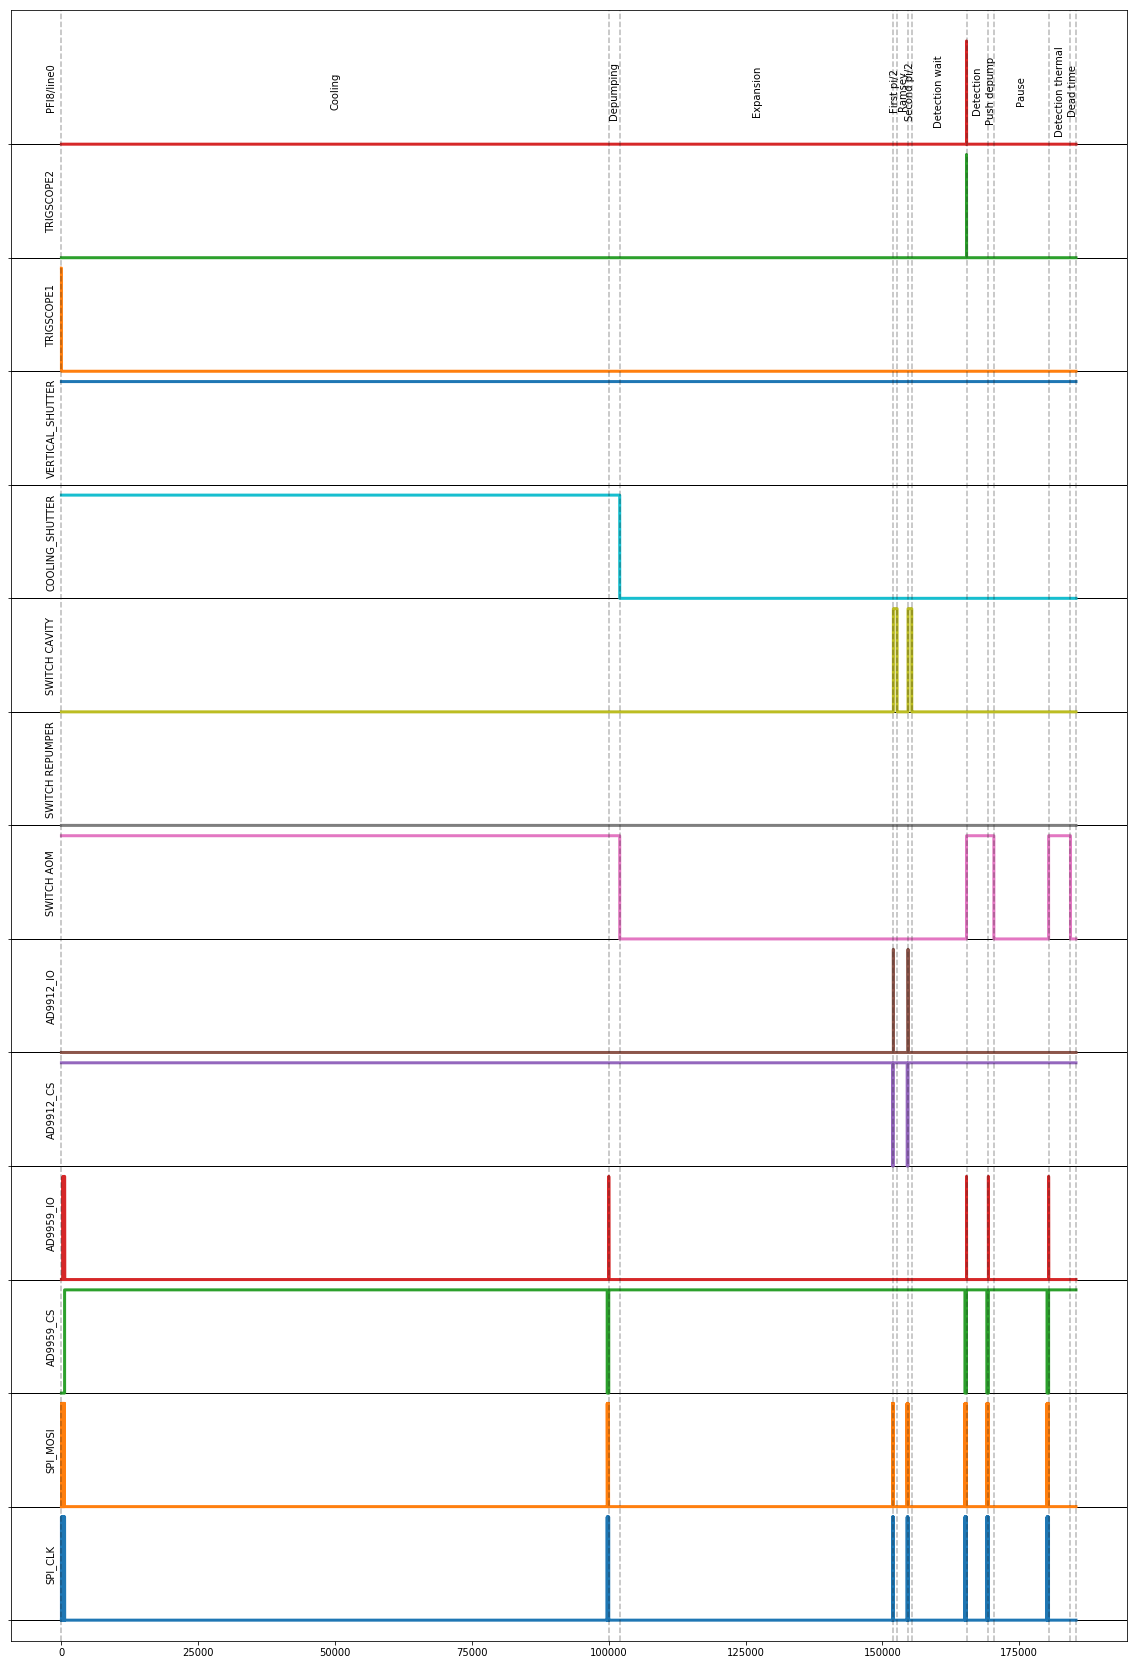

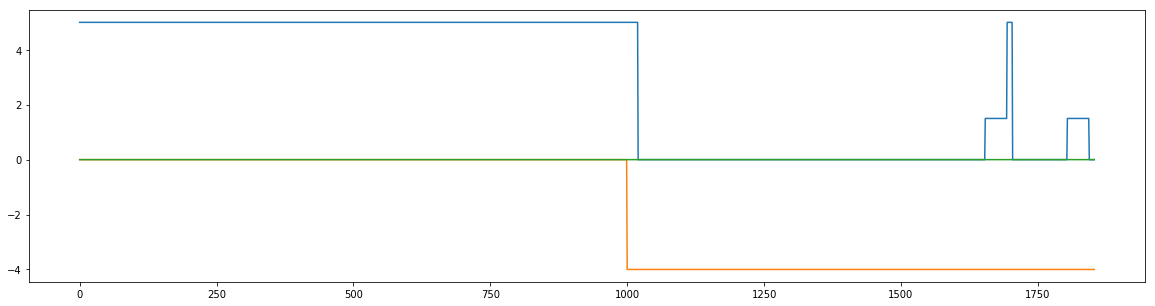

In [24]:
t0 = time.perf_counter()

sequencing_rate = seq_settings['sequencing rate']
acquisition_rate = seq_settings['acquisition']['acquisition rate']

DDS = dict()
for dds_id, dds_params in dds_conf['dds ids'].items():
    if dds_params['type'] == 'AD9959':
        DDS[dds_id] = AD9959(
            ref_clock=dds_params['ref clock'], 
            pll_divider=dds_params['pll divider'], 
            LSB_first=AD9959.CSR_BITS.MSB_First, 
            serial_io_mode=AD9959.CSR_BITS.IO3Wire,
        )
    if dds_params['type'] == 'AD9912':
        DDS[dds_id] = AD9912(
            ref_clock=dds_params['ref clock'],
        )

phases = deepcopy(seq_phases)

#pprint(phases)
#print('-'*100)

# Compute total length, add timings and indexes to phases
current_length = 0
for phase in phases:
    phase['idx_beg'] = int(sequencing_rate*current_length)
    phase['t_beg'] = current_length
    current_length += phase['length']
    phase['idx_end'] = int(sequencing_rate*current_length)
    phase['t_end'] = current_length
total_length = current_length    
print('Sequence length : {:.1f} ms'.format(total_length*1e3))
    
# We add one sample at the end to put all signals to default states
n_samples = int(total_length*sequencing_rate) + 1
sequence_do = np.zeros(n_samples, dtype=np.uint32)
sequence_ao = np.zeros((len(nidaq_conf['ANALOG_OUTPUTS']), n_samples))

# Set default levels for digital and analog outputs
ao_lines_idx = {
    ao_name: idx 
    for idx, ao_name 
    in enumerate(nidaq_conf['ANALOG_OUTPUTS'])
}
for ao_name in nidaq_conf['ANALOG_OUTPUTS']:
    ao_conf = nidaq_conf['ANALOG_OUTPUTS'][ao_name]
    sequence_ao[ao_conf['LINE'], :] = ao_conf['DEFAULT']
    
bits = 0
for do_name in nidaq_conf['DEFAULT_HIGH_LINES']:
    bits |= 1 << nidaq_conf['DIGITAL_OUTPUTS'][do_name]
sequence_do |= np.uint32(bits)


# Check frequency changes that need to move between phases        
for num_phase, current_phase in enumerate(phases):
    previous_phase = phases[num_phase - 1] if num_phase > 0 else None
    next_phase = phases[num_phase + 1] if num_phase < len(phases)-1 else None
    
    if 'frequency_changes' in current_phase:
        freq_changes = current_phase['frequency_changes']
        
        freq_changes_updated = []
        
        pulse_ttls = current_phase.get('pulse_ttls', [])
        
        freq_changes_previous = None
        
        for freq_change in freq_changes:
            if freq_change['when'] == 'before':
                if freq_changes_previous is None:
                    if previous_phase is None:
                        raise ValueError('Cannot program frequency change {} with "before" if it is the first phase.'.format(freq_change))
                    freq_changes_previous = previous_phase.get('frequency_changes', [])
                    
                if freq_change['io_update'] == 'start':
                    freq_destination = freq_change['destination']
                    dds_id = dds_conf['freq change destinations'][freq_destination]['dds id']
                    io_line_name = dds_conf['dds ids'][dds_id]['io update line']
                    pulse_ttls.append(io_line_name)
                    
                freq_change['when'] = 'end'
                freq_change['io_update'] = 'next_phase'
                freq_changes_previous.append(freq_change)

            else:
                freq_changes_updated.append(freq_change)
                
        if freq_changes_previous:
            previous_phase['frequency_changes'] = freq_changes_previous
        

        if not freq_changes_updated:
            current_phase.pop('frequency_changes')
        else:
            current_phase['frequency_changes'] = freq_changes_updated
            
        if pulse_ttls:
            current_phase['pulse_ttls'] = pulse_ttls

# DDS helper objects
dds_9959 = AD9959(
    ref_clock=100e6, pll_divider=5, 
    LSB_first=AD9959.CSR_BITS.MSB_First, 
    serial_io_mode=AD9959.CSR_BITS.IO3Wire,
)
dds_9959_int_to_chan = {
    0: AD9959.CHANNEL.CH0,
    1: AD9959.CHANNEL.CH1,
    2: AD9959.CHANNEL.CH2,
    3: AD9959.CHANNEL.CH3,
}
dds_9912= AD9912(ref_clock=875e6)

#pprint(phases)


for phase in phases:
    idx_beg, idx_end = phase['idx_beg'], phase['idx_end']
    seq_phase = sequence_do[idx_beg:idx_end]

    if 'high_ttls' in phase:
        bits = 0
        for do_name in phase['high_ttls']:
            bits |= 1 << nidaq_conf['DIGITAL_OUTPUTS'][do_name]
        seq_phase |= np.uint32(bits)
    if 'low_ttls' in phase:
        bits = 0
        for do_name in phase['low_ttls']:
            bits |= 1 << nidaq_conf['DIGITAL_OUTPUTS'][do_name]
        seq_phase &= ~np.uint32(bits)
    if 'pulse_ttls' in phase:
        bits = 0
        for do_name in phase['pulse_ttls']:
            bits |= 1 << nidaq_conf['DIGITAL_OUTPUTS'][do_name]
        seq_phase[0] |= np.uint32(bits)
        
    if 'ao_values' in phase:
        for ao_name, value in phase['ao_values'].items():
            sequence_ao[ao_lines_idx[ao_name], idx_beg:idx_end] = value
        

    if 'frequency_changes' in phase:                
        ref_idx_spi_beg = phase['idx_beg']
        ref_idx_spi_end   = phase['idx_end']

        for freq_change in phase['frequency_changes']:

            freq_dest = freq_change['destination']
            dds_id = dds_conf['freq change destinations'][freq_dest]['dds id']
            dds_type = dds_conf['dds ids'][dds_id]['type']
                        
            # Can this be abstracted ?
            if dds_type == 'AD9959':
                # get words
                channel_int = dds_conf['freq change destinations'][freq_dest]['channel']
                words = DDS[dds_id].get_set_single_frequency_words(
                    channels=dds_9959_int_to_chan[channel_int],
                    frequency=freq_change['freq'],
                )
            if dds_type == 'AD9912':
                words = DDS[dds_id].get_set_frequency_words(frequency=freq_change['freq'])
                
            
            spi_clk, spi_sequence = prepare_sequence_for_spi(words=words,)

            spi_len = len(spi_clk)
            if freq_change['when'] == 'start':
                idx_beg_spi = ref_idx_spi_beg
                idx_end_spi = idx_beg_spi + spi_len
                ref_idx_spi_beg = idx_end_spi
                
            elif freq_change['when'] == 'end':
                idx_end_spi = ref_idx_spi_end
                idx_beg_spi = idx_end_spi - spi_len
                ref_idx_spi_end = idx_beg_spi

            # insert spi sequence
            sequence_do[idx_beg_spi:idx_end_spi] |= (
                spi_clk << nidaq_conf['DIGITAL_OUTPUTS'][nidaq_conf['SPI']['CLK_LINE']] | 
                spi_clk << nidaq_conf['DIGITAL_OUTPUTS'][nidaq_conf['SPI']['CLK_MON_LINE']] |
                spi_sequence << nidaq_conf['DIGITAL_OUTPUTS'][nidaq_conf['SPI']['MOSI_LINE']]
            )
            
            cs_line_name = dds_conf['dds ids'][dds_id]['cs line']
            sequence_do[idx_beg_spi:idx_end_spi] &= ~np.uint32( 1 << nidaq_conf['DIGITAL_OUTPUTS'][cs_line_name] )
            
            # add io update if necessary
            if freq_change['io_update'] == 'immediate':
                io_update_line_name = dds_conf['dds ids'][dds_id]['io update line']
                sequence_do[idx_end_spi] |= np.uint32( 1 << nidaq_conf['DIGITAL_OUTPUTS'][io_update_line_name])

        if ref_idx_spi_beg > ref_idx_spi_end:
            raise RuntimeError('SPI signals overlap in phase {}'.format(phase['name']))
            

# # Acquisition configuration            
        
phase_beg_acq = find_phase_by_name(phases, seq_settings['acquisition']['begin at'])
phase_end_acq = find_phase_by_name(phases, seq_settings['acquisition']['end at'])
        

t_beg_acq = phase_beg_acq['t_beg']
dt_acq = phase_end_acq['t_end'] - t_beg_acq
n_samples_acq = int(dt_acq*acquisition_rate)
idx_beg_acq = int(t_beg_acq*sequencing_rate)

sequence_do[idx_beg_acq] |= np.uint32(1 << nidaq_conf['DIGITAL_OUTPUTS']['PFI8'])

acquired_data = np.zeros((len(nidaq_conf['ANALOG_INPUTS']), n_samples_acq), dtype=np.float64)
       
#  #  Plot the sequence

print('Took {:.0f} ms'.format(1e3*(time.perf_counter() - t0)))

fig, ax = ttl_plot(
    words=sequence_do, 
#     words=sequence[250:300], 
    bits=(
        nidaq_conf['DIGITAL_OUTPUTS']['SPI_CLK'], 
        nidaq_conf['DIGITAL_OUTPUTS']['SPI_MOSI'],
        nidaq_conf['DIGITAL_OUTPUTS']['AD9959_CS'],
        nidaq_conf['DIGITAL_OUTPUTS']['AD9959_IO_UPDATE'],
        nidaq_conf['DIGITAL_OUTPUTS']['AD9912_CS'],
        nidaq_conf['DIGITAL_OUTPUTS']['AD9912_IO_UPDATE'],
        nidaq_conf['DIGITAL_OUTPUTS']['AOM_SW'],
        nidaq_conf['DIGITAL_OUTPUTS']['REPUMPER_SW'],
        nidaq_conf['DIGITAL_OUTPUTS']['CAVITY_SW'],
        nidaq_conf['DIGITAL_OUTPUTS']['COOLING_SHUTTER'],
        nidaq_conf['DIGITAL_OUTPUTS']['VERTICAL_SHUTTER'],
        nidaq_conf['DIGITAL_OUTPUTS']['TRIGSCOPE1'],
        nidaq_conf['DIGITAL_OUTPUTS']['TRIGSCOPE2'],
        nidaq_conf['DIGITAL_OUTPUTS']['PFI8'],
    ),
    labels=(
        'SPI_CLK',
        'SPI_MOSI',
        'AD9959_CS',
        'AD9959_IO',
        'AD9912_CS',
        'AD9912_IO',
        'SWITCH AOM',
        'SWITCH REPUMPER',
        'SWITCH CAVITY',
        'COOLING_SHUTTER',
        'VERTICAL_SHUTTER',
        'TRIGSCOPE1',
        'TRIGSCOPE2',
        'PFI8/line0'
    ),
    fig_kwargs=dict(figsize=(20, 30)),
)

# ax.set_xlim(0, 400)
yl = ax.get_ylim()

separation_lines_kwargs = dict(linestyle='--', color=[0.1]*3, alpha=0.3)
for phase in phases:
    ax.plot([phase['idx_beg']]*2, yl, **separation_lines_kwargs)
    ax.text(
        0.5*(phase['idx_end']+phase['idx_beg']), 
        yl[1]*0.95, 
        phase['name'],
        verticalalignment='center',
        horizontalalignment='center',
        rotation=90,
    )
ax.plot([phases[-1]['idx_end']]*2, yl, **separation_lines_kwargs)
fig.savefig(fname='data/sequence_plot.pdf')

fig, ax = plt.subplots(figsize=(20, 5))
for ao_name, num in ao_lines_idx.items():
    ax.plot(sequence_ao[num, ::100])

In [25]:
pprint(nidaq_conf['ANALOG_OUTPUTS'])
pprint(ao_lines_idx)
used_ao_lines = sorted(((idx_in_seq, line_name) for line_name, idx_in_seq in ao_lines_idx.items()), key=lambda e: e[0])
pprint(used_ao_lines)

pprint(nidaq_conf['ANALOG_INPUTS'])
used_ai_lines = sorted((line_name for line_name in nidaq_conf['ANALOG_INPUTS']), key=lambda line_name: nidaq_conf['ANALOG_INPUTS'][line_name]['LINE'])
pprint(used_ai_lines)
ai_lines_idx = {line_name: idx for idx, line_name in enumerate(used_ai_lines)}
pprint(ai_lines_idx)

{'AOM_AMP': {'DEFAULT': 0, 'LINE': 0, 'MAX': 5, 'MIN': -5},
 'PHD_OFFSET': {'DEFAULT': 0, 'LINE': 2, 'MAX': 5, 'MIN': -5},
 'REPUMPER_AMP': {'DEFAULT': -4.0, 'LINE': 1, 'MAX': 5, 'MIN': -5}}
{'AOM_AMP': 0, 'PHD_OFFSET': 2, 'REPUMPER_AMP': 1}
[(0, 'AOM_AMP'), (1, 'REPUMPER_AMP'), (2, 'PHD_OFFSET')]
{'ABS_COARSE': {'LINE': 2, 'MAX': 10, 'MIN': -10},
 'ABS_FINE': {'LINE': 0, 'MAX': 2, 'MIN': -2},
 'NORM_COARSE': {'LINE': 3, 'MAX': 10, 'MIN': -10},
 'NORM_FINE': {'LINE': 1, 'MAX': 2, 'MIN': -2}}
['ABS_FINE', 'NORM_FINE', 'ABS_COARSE', 'NORM_COARSE']
{'ABS_COARSE': 2, 'ABS_FINE': 0, 'NORM_COARSE': 3, 'NORM_FINE': 1}


Tasks took : 257.2 ms
Took 289.6 ms


Text(0,0.5,'Phd signals (V)')

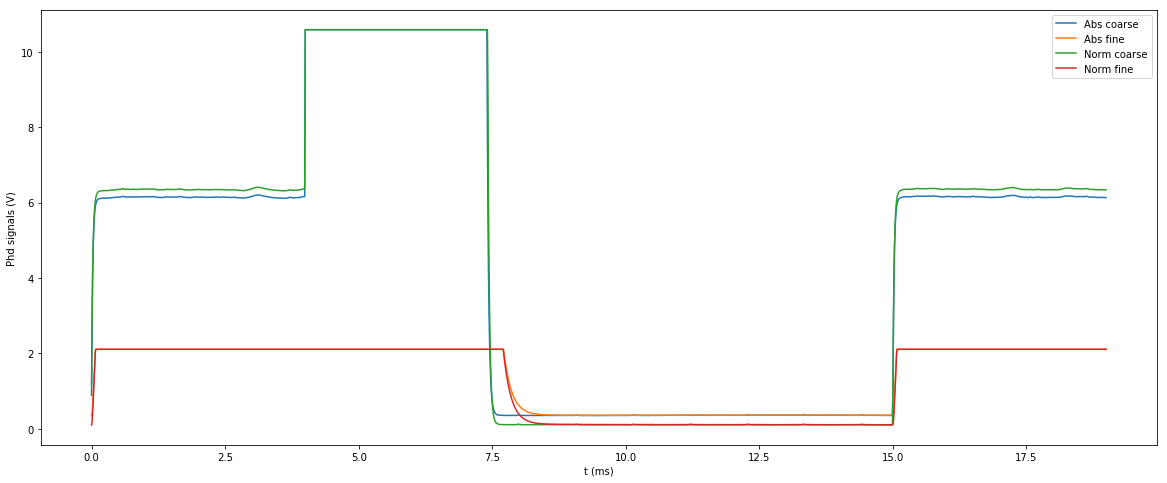

In [26]:
do_lines_description = '/Dev1/port0'

t0 = time.perf_counter()

tasks = []
try:
    taskdo = nidaqmx.Task('Digital Output')
    tasks.append(taskdo)
    
    taskao = nidaqmx.Task('Analog Output')
    tasks.append(taskao)
    
    taskai = nidaqmx.Task('Analog Input')
    tasks.append(taskai)
    
    taskctr = nidaqmx.Task('Counter')
    tasks.append(taskctr)
    
    taskctr2 = nidaqmx.Task('Acquisition counter')
    tasks.append(taskctr2)
    
    taskctr.co_channels.add_co_pulse_chan_freq(
        counter='/Dev1/Ctr0',
        freq=sequencing_rate,
        units=nidaqmx.constants.FrequencyUnits.HZ,
    )
    taskctr.timing.cfg_implicit_timing(
        sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
    )

    taskctr2.co_channels.add_co_pulse_chan_freq(
        counter='/Dev1/Ctr1',
        freq=acquisition_rate,
        units=nidaqmx.constants.FrequencyUnits.HZ,
    )
    taskctr2.timing.cfg_implicit_timing(
        sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
    )
    taskctr2.triggers.start_trigger.cfg_dig_edge_start_trig(trigger_source='/Dev1/Ctr0InternalOutput')


    
    taskdo.do_channels.add_do_chan(
        lines=do_lines_description,
        line_grouping=nidaqmx.constants.LineGrouping.CHAN_FOR_ALL_LINES,
    )
    taskdo.timing.cfg_samp_clk_timing(
        source='/Dev1/Ctr0InternalOutput',
        samps_per_chan=n_samples,
        sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
        rate=sequencing_rate,
    )
    taskdo.out_stream.regen_mode = nidaqmx.constants.RegenerationMode.ALLOW_REGENERATION
    
    for _, line_name in used_ao_lines:
        line_conf = nidaq_conf['ANALOG_OUTPUTS'][line_name]
        taskao.ao_channels.add_ao_voltage_chan(
            physical_channel='/Dev1/ao{:.0f}'.format(line_conf['LINE']),
            units=nidaqmx.constants.VoltageUnits.VOLTS,
            min_val=line_conf['MIN'],
            max_val=line_conf['MAX'],
        )
    
    taskao.timing.cfg_samp_clk_timing(
        source='/Dev1/Ctr0InternalOutput',
        samps_per_chan=n_samples,
        sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
        rate=sequencing_rate,
    )
    
    for line_name in used_ai_lines:
        line_conf = nidaq_conf['ANALOG_INPUTS'][line_name]
        taskai.ai_channels.add_ai_voltage_chan(
            physical_channel='/Dev1/ai{:.0f}'.format(line_conf['LINE']),
            units=nidaqmx.constants.VoltageUnits.VOLTS,
            min_val=line_conf['MIN'],
            max_val=line_conf['MAX'],
        )

    taskai.timing.cfg_samp_clk_timing(
        source='/Dev1/Ctr1InternalOutput',
        sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
        rate=acquisition_rate,
        samps_per_chan=n_samples_acq,
    )
    taskai.triggers.start_trigger.cfg_dig_edge_start_trig(trigger_source='/Dev1/PFI8')

    
    
    ao_stream_writer = nidaqmx.stream_writers.AnalogMultiChannelWriter(
        auto_start=False, 
        task_out_stream=taskao.out_stream,
    )
    ao_stream_writer.write_many_sample(
        data=sequence_ao, 
        timeout=10.0,
    )


    do_stream_writer = nidaqmx.stream_writers.DigitalSingleChannelWriter(
        auto_start=False,
        task_out_stream=taskdo.out_stream,
    )
    do_stream_writer.write_many_sample_port_uint32(
        data=sequence_do,
        timeout=10.0,
    )

    t1 = time.perf_counter()
    taskai.start()
    taskao.start()
    taskdo.start()
    taskctr2.start()
    taskctr.start()

    ai_stream_reader = nidaqmx.stream_readers.AnalogMultiChannelReader(task_in_stream=taskai.in_stream)
    ai_stream_reader.read_many_sample(
        data=acquired_data,
        number_of_samples_per_channel=n_samples_acq,
        timeout=10.0,
    )


    taskdo.wait_until_done(timeout=5.0)
    print('Tasks took : {:.1f} ms'.format(1e3*(time.perf_counter() - t1)))
    
except nidaqmx.DaqError as e:
    if e.error_type != nidaqmx.errors.DAQmxErrors.WAIT_UNTIL_DONE_DOES_NOT_INDICATE_DONE:
        print('A Daq error has occured :')
        print('_'*100)
        print(e)
        print('¯'*100)
        raise
    else:
        print('Finished after timeout')
finally:
    print('Took {:.1f} ms'.format(1e3*(time.perf_counter() - t0)))
    for task in tasks:
        task.close()

        

current_shot = get_current_shot_number()
current_shot_filename = 'data/shot_{:%Y%m%d}_{:03.0f}.gz'.format(datetime.datetime.now(), current_shot)
np.savetxt(current_shot_filename, acquired_data.T, header='phd1_fine, phd2_fine, phd1_coarse, phd2_coarse')
        
fig, ax = plt.subplots(figsize=(20, 8))
t = np.arange(n_samples_acq)/acquisition_rate*1e3
ax.plot(t, acquired_data[ai_lines_idx['ABS_COARSE'], :], label='Abs coarse')
ax.plot(t, -acquired_data[ai_lines_idx['ABS_FINE'], :], label='Abs fine')
ax.plot(t, acquired_data[ai_lines_idx['NORM_COARSE'], :], label='Norm coarse')
ax.plot(t, -acquired_data[ai_lines_idx['NORM_FINE'], :], label='Norm fine')
ax.legend()
ax.set_xlabel('t (ms)')
ax.set_ylabel('Phd signals (V)')

In [14]:
win_len = 3.5
win1_t_beg = 0.3
win1_t_end = win1_t_beg + win_len

win2_t_beg = 15 + 0.2
win2_t_end = win2_t_beg + win_len

-2.111430180692337
-2.1107541515232806
5.775229431009203
5.788287881269141
222974.94134220577


(0, 1.0)

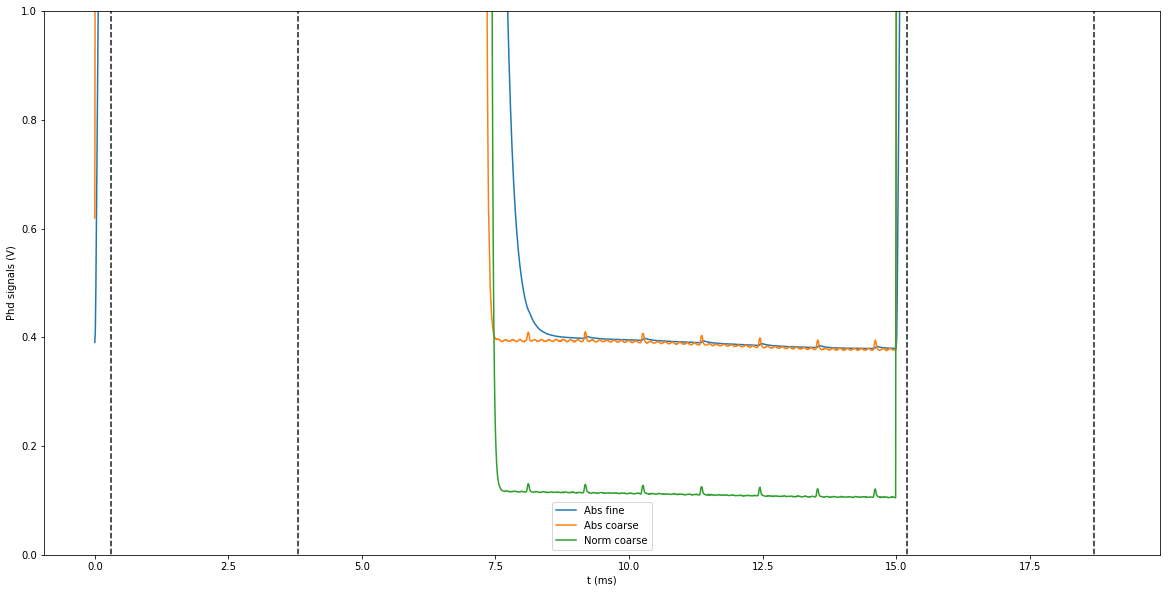

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(t, -acquired_data[ai_lines_idx['ABS_FINE'], :], label='Abs fine')
ax.plot(t, acquired_data[ai_lines_idx['ABS_COARSE'], :], label='Abs coarse')
ax.plot(t, acquired_data[ai_lines_idx['NORM_COARSE'], :], label='Norm coarse')
ax.legend()
ax.set_xlabel('t (ms)')
ax.set_ylabel('Phd signals (V)')

yl = ax.get_ylim()

line_params = dict(linestyle='--', color=[0.1]*3)
ax.plot([win1_t_beg]*2, yl, **line_params)
ax.plot([win1_t_end]*2, yl, **line_params)
ax.plot([win2_t_beg]*2, yl, **line_params)
ax.plot([win2_t_end]*2, yl, **line_params)

idx_win1_beg = int(win1_t_beg * 1e-3 * acquisition_rate)
idx_win1_end = int(win1_t_end * 1e-3 * acquisition_rate)
idx_win2_beg = int(win2_t_beg * 1e-3 * acquisition_rate)
idx_win2_end = int(win2_t_end * 1e-3 * acquisition_rate)

win1_phd1 = acquired_data[ai_lines_idx['ABS_FINE'],    idx_win1_beg:idx_win1_end]
win1_phd2 = acquired_data[ai_lines_idx['NORM_COARSE'], idx_win1_beg:idx_win1_end]
win2_phd1 = acquired_data[ai_lines_idx['ABS_FINE'],    idx_win2_beg:idx_win2_end]
win2_phd2 = acquired_data[ai_lines_idx['NORM_COARSE'], idx_win2_beg:idx_win2_end]
 
print(win1_phd1.mean())
print(win2_phd1.mean())
print(win1_phd2.mean())
print(win2_phd2.mean())
    
    
trans1 = win1_phd1.mean() / win1_phd2.mean()
trans2 = win2_phd1.mean() / win2_phd2.mean()

N = 8.6465e7 * np.log(trans1/trans2)
print(N)
    
# ax.set_ylim(6, 7)
ax.set_ylim(0, 1.0)